<a href="https://colab.research.google.com/github/GenAIUnplugged/tensorflow_series/blob/main/CNN_Models_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
(df_train,ds_test),ds_info = tfds.load('tf_flowers',
                                        split=['train[:70%]','train[70%:]'],
                                        as_supervised=True,
                                        with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.JJYFRU_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})

In [4]:
num_classes = ds_info.features['label'].num_classes
num_classes

5

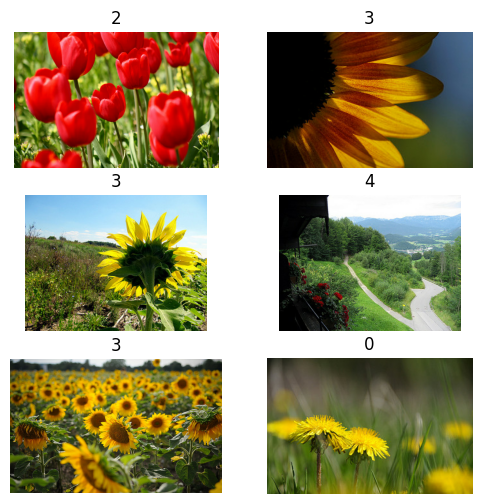

In [5]:
plt.figure(figsize=(6,6))
for i,(image,label) in enumerate(df_train.take(6)):
  plt.subplot(3,2,i+1)
  plt.imshow(image.numpy().astype('uint8'))
  plt.title(str(label.numpy()))
  plt.grid(False)
  plt.axis('off')
plt.show()

In [6]:
def preprocess(image,label):
  resized_image = tf.image.resize(image,[128,138])
  image = tf.cast(resized_image,tf.float32)/255.0
  return image,label

In [7]:
df_train = df_train.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
df_train = df_train.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.cache().batch(32).prefetch(tf.data.AUTOTUNE)

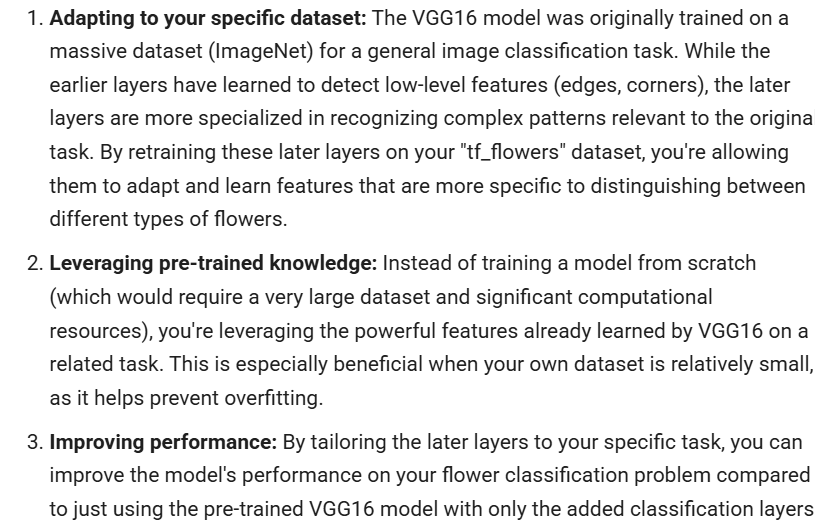

# VGG Model

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,MaxPooling2D

In [10]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(128,138,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
vgg_model.trainable = True

In [12]:
#Choose how many layers to fine tune
#We will unfreeze and train the last 4 layers
for layer in vgg_model.layers[:-4]:
  layer.trainable = False

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

In [14]:
model = Sequential([
    vgg_model,
    GlobalAveragePooling2D(),
    Dense(num_classes,activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 7,081,989 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [16]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
history = model.fit(df_train,validation_data=ds_test,epochs=10,callbacks=[earlystopping])

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.2612 - loss: 1.7213 - val_accuracy: 0.4078 - val_loss: 1.4341
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.3963 - loss: 1.3605 - val_accuracy: 0.4187 - val_loss: 1.3435
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.4215 - loss: 1.2974 - val_accuracy: 0.4414 - val_loss: 1.3156
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.4496 - loss: 1.2561 - val_accuracy: 0.4487 - val_loss: 1.2943
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4751 - loss: 1.2354 - val_accuracy: 0.5195 - val_loss: 1.0616
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.6212 - loss: 0.8843 - val_accuracy: 0.8174 - val_loss: 0.4996
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8312 - loss: 0.4507 - val_accuracy: 0.8574 - val_loss: 0.4351
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8894 - loss: 0.3037 - val_accu

In [18]:
loss,acc = model.evaluate(ds_test)
print('Loss:',loss)
print('Accuracy:',acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8636 - loss: 0.4180
Loss: 0.40280938148498535
Accuracy: 0.8728428483009338


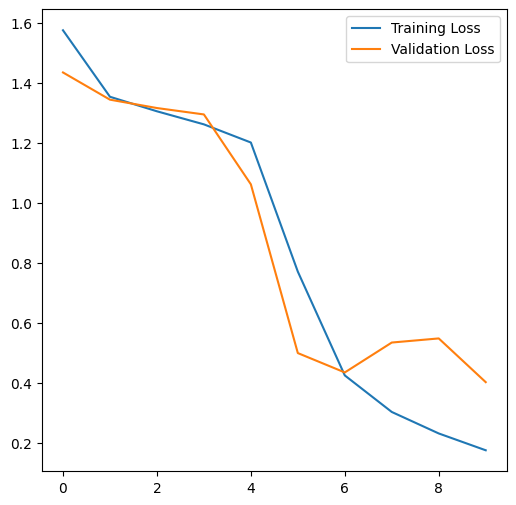

In [19]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

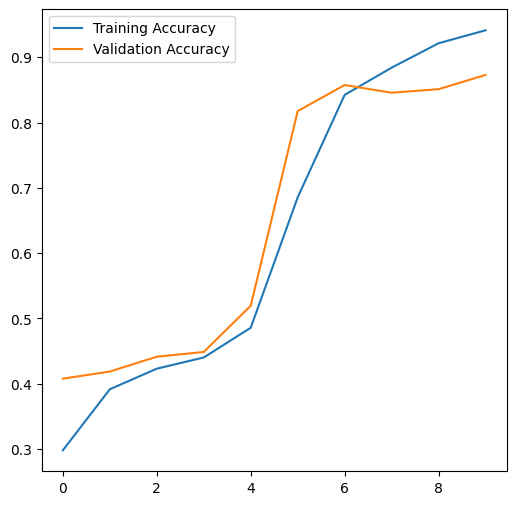

In [20]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

In [21]:
from tensorflow.keras.applications import ResNet50

In [22]:
restnet = ResNet50(weights='imagenet',include_top=False,input_shape=(128,138,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
restnet.trainable = True
for layer in restnet.layers[:-4]:
  layer.trainable = False

In [24]:
model = Sequential([
    restnet,
    GlobalAveragePooling2D(),
    Dense(num_classes,activation='softmax')
])

In [25]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [26]:
history = model.fit(df_train,validation_data=ds_test,epochs=10,callbacks=[earlystopping])

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.3511 - loss: 1.5337 - val_accuracy: 0.2589 - val_loss: 2.1501
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.4661 - loss: 1.3337 - val_accuracy: 0.1744 - val_loss: 1.8215
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4748 - loss: 1.2958 - val_accuracy: 0.4351 - val_loss: 1.5118
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.4950 - loss: 1.2537 - val_accuracy: 0.3115 - val_loss: 2.0380
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5052 - loss: 1.2342 - val_accuracy: 0.1898 - val_loss: 1.7942
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5203 - loss: 1.2219 - val_accuracy: 0.3070 - val_loss: 1.5928
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5484 - loss: 1.1968 - val_accuracy: 0.4196 - val_loss: 1.4348
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5311 - loss: 1.1764 - val_accuracy: 0.4133 -

In [27]:
loss,acc = model.evaluate(ds_test)
print('Loss:',loss)
print('Accuracy:',acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2847 - loss: 1.6684
Loss: 1.6592692136764526
Accuracy: 0.2779291570186615


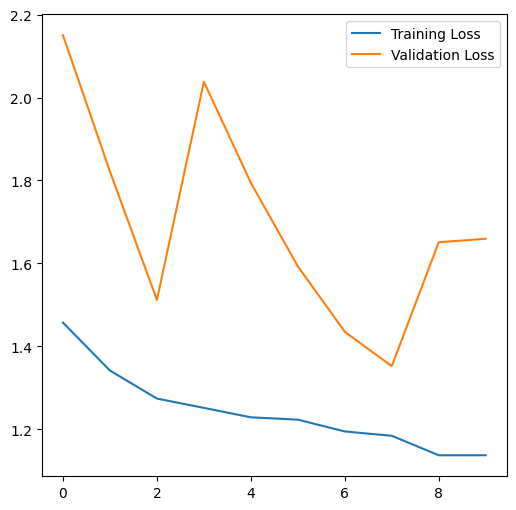

In [28]:
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

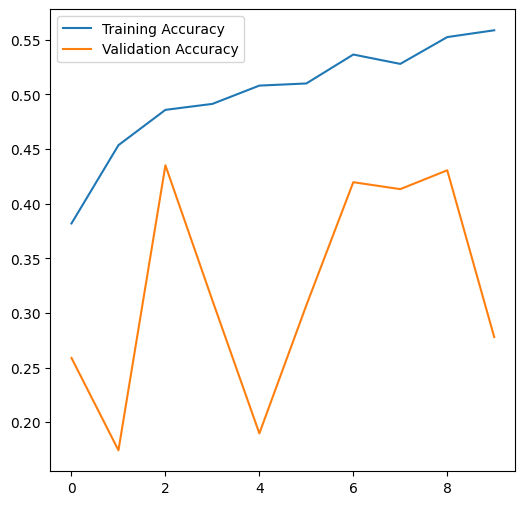

In [29]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()